## Install Dependencies and Retrieve Video

Install the required dependencies for this project. We'll be using Ultralytics' YOLOv8 model for inference, and Supervision for drawing our polygons and calculating how many objects appear in each annotated zone.

In [ ]:
!pip install ultralytics supervision -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 kB 8.9 MB/s eta 0:00:00


## Initialize the Model and Video

In the code snippet below, we import the required dependencies for our project, initialize a YOLOv8 model, and load a video into our project.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
###tracking and Analyzing the movements of a fly
###Initial setup and model loading
import numpy as np
import supervision as sv
import cv2

from ultralytics import YOLO

### A pre-trained YOLO model is loaded from the specified path
## best.pt contains the trained weights of the model.

model = YOLO('/content/drive/MyDrive/OPS-Yolov8_v1/runs/detect/train4/weights/best.pt')

### video path setup,
VIDEO = "/content/drive/MyDrive/OPS-Yolov8_v1/IMG-to-MOV-4.mp4"

## Initializes default color palette from supervision lib
## Retrieves meta data about the video from its file path.
colors = sv.ColorPalette.default()
video_info = sv.VideoInfo.from_video_path(VIDEO)
video_info

SupervisionWarnings: default is deprecated: `ColorPalette.default()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.DEFAULT` instead.


VideoInfo(width=640, height=640, fps=30, total_frames=1719)

Next, go to [PolygonZone](https://roboflow.github.io/polygonzone/) and draw polygons on your image. PolygonZone returns a list of polygon coordinates in both NumPy and JSON formats. Copy the NumPy output into the cell below:

In [ ]:
# Coordinates of shape 1: [(267, 302), (302, 286), (321, 258), (328, 223), (331, 177), (141, 32), (80, 61), (66, 139)]
# Coordinates of shape 2: [(271, 310), (306, 293), (316, 282), (349, 288), (371, 305), (380, 572), (358, 617), (307, 624), (272, 586)]
# Coordinates of shape 3: [(319, 276), (352, 282), (373, 298), (496, 217), (554, 166), (579, 124), (577, 72), (539, 48), (476, 66), (344, 172), (334, 209)]


In [ ]:
### Drawing polygons on our Image
## Creating co-ordinates for 3 arms
polygons = [
  np.array([
    (314, 256), (247, 309), (52, 192), (25, 88), (97, 32), (206, 39), (306, 123), (328, 175)
  ]),
  np.array([
    (319, 254), (332, 178), (344, 157), (406, 98), (467, 51), (548, 34), (586, 68), (614, 140), (585, 195), (540, 242), (468, 286), (403, 313), (357, 285)
  ]),
  np.array([
    (251, 317), (317, 261), (395, 316), (402, 532), (394, 614), (355, 637), (256, 635), (243, 480)
  ]),
]

## Run Inference

Using the YOLOv8 model we initialized earlier, as well as our Supervision objects, we can draw polygons on the first frame on our image and count the number of objects that appear.

First, let's initialize our zones:

In [ ]:
# initialize our zones
## setting up zones within the video and creating annotators for both the polygonal zones and the fly.
zones = [
    sv.PolygonZone(
        polygon=polygon,
        frame_resolution_wh=video_info.resolution_wh
    )

    ### This creates a list of PolygonZone objects, one for each polygon defined in the polygons array.
    for polygon
    in polygons
]

## drawing the zone boundaries and labels in the video.
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=1,
        text_thickness=2,
        text_scale=1
    )
    for index, zone
    in enumerate(zones)
]

## bounding boxes will be drawn around detected objects (flies) within the zones.
box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=1,
        text_thickness=1,
        text_scale=1
        )
    for index
    in range(len(polygons))
]



SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


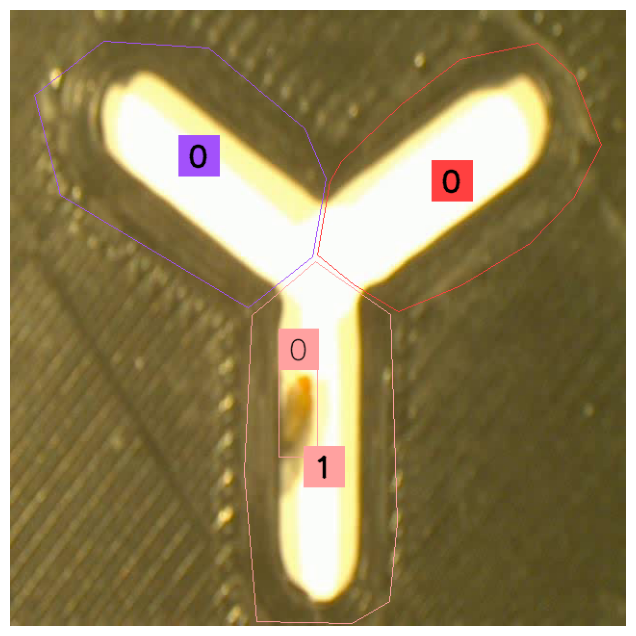

In [ ]:
## processes video data to detect and visualize objects within defined spatial zones and it analyzes fliy behaviour within the zones defined.
generator = sv.get_video_frames_generator(VIDEO)     ## allows to process the video one frame at a time without loading the entire video into memory, which is efficient for handling large video files.
iterator = iter(generator)                                ## Converts the generator into an iterator to facilitate the sequential processing of video frames.

frame = next(iterator)

results = model(frame, imgsz=1280, verbose=False)[0]             ## Passes the current frame to the pre-loaded YOLO model for object detection.
detections = sv.Detections.from_ultralytics(results)             ## Converts the raw detection results from the YOLO model into a format that the supervision library can handle,

for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):  ##  Iterates over each defined zone and its corresponding annotators.
    mask = zone.trigger(detections=detections)
    detections_filtered = detections[mask]
    frame = box_annotator.annotate(scene=frame, detections=detections_filtered)
    frame = zone_annotator.annotate(scene=frame)

sv.plot_image(frame, (8, 8))


In [ ]:
import pandas as pd

# Initialize a DataFrame to log detection details
detections_log = pd.DataFrame(columns=['Frame', 'Zone', 'Class_Name', 'Confidence'])  ## store detection information for each frame processed.
detections_buffer = []

def process_frame(frame: np.ndarray, frame_index) -> np.ndarray:
    global detections_buffer  # Use a buffer to collect data for this frame

    results = model(frame, imgsz=1280, verbose=False)[0] # Consider only one object in the zone, though multiple objects detected by Yolo model
    detections = sv.Detections.from_ultralytics(results)

    for idx, (zone, zone_annotator, box_annotator) in enumerate(zip(zones, zone_annotators, box_annotators)):
        mask = zone.trigger(detections=detections)
        detections_filtered = detections[mask]

        if len(detections_filtered.xyxy) > 0:
            highest_confidence_index = np.argmax(detections_filtered.confidence)
            class_name = detections_filtered.data['class_name'][highest_confidence_index]
            confidence = detections_filtered.confidence[highest_confidence_index]

            # Append the highest confidence detection to the buffer
            detections_buffer.append({
                'Frame': frame_index,
                'Zone': idx,
                'Class_Name': class_name,
                'Confidence': confidence
            })
            print(detections_buffer[-1])

        frame = box_annotator.annotate(scene=frame, detections=detections_filtered, skip_label=True)
        frame = zone_annotator.annotate(scene=frame)

    return frame

sv.process_video(source_path=VIDEO, target_path="result.mp4", callback=process_frame)

detections_log = pd.concat([detections_log, pd.DataFrame(detections_buffer)], ignore_index=True)

detections_log.to_excel("detections_log.xlsx", index=False)


{'Frame': 0, 'Zone': 2, 'Class_Name': 'fly', 'Confidence': 0.55222774}
{'Frame': 1, 'Zone': 2, 'Class_Name': 'fly', 'Confidence': 0.6051138}
{'Frame': 2, 'Zone': 2, 'Class_Name': 'fly', 'Confidence': 0.52068126}
{'Frame': 3, 'Zone': 2, 'Class_Name': 'fly', 'Confidence': 0.5115349}
{'Frame': 4, 'Zone': 2, 'Class_Name': 'fly', 'Confidence': 0.41367665}
{'Frame': 5, 'Zone': 2, 'Class_Name': 'fly', 'Confidence': 0.60365427}
{'Frame': 6, 'Zone': 2, 'Class_Name': 'fly', 'Confidence': 0.6318704}
{'Frame': 7, 'Zone': 2, 'Class_Name': 'fly', 'Confidence': 0.54776144}
{'Frame': 8, 'Zone': 2, 'Class_Name': 'fly', 'Confidence': 0.6256776}
{'Frame': 9, 'Zone': 2, 'Class_Name': 'fly', 'Confidence': 0.33863392}
{'Frame': 14, 'Zone': 2, 'Class_Name': 'fly', 'Confidence': 0.3185369}
{'Frame': 16, 'Zone': 2, 'Class_Name': 'fly', 'Confidence': 0.37100342}
{'Frame': 17, 'Zone': 2, 'Class_Name': 'fly', 'Confidence': 0.30471045}
{'Frame': 18, 'Zone': 2, 'Class_Name': 'fly', 'Confidence': 0.38458142}
{'Frame

## Fly vs Zone Stats

In [ ]:
detections_log.head(6)

,Frame,Zone,Class_Name,Confidence
0,0,2,fly,0.552228
1,1,2,fly,0.605114
2,2,2,fly,0.520681
3,3,2,fly,0.511535
4,4,2,fly,0.413677
5,5,2,fly,0.603654


In [ ]:
def trace_continuous_time(df):
    traces = []
    current_zone = None
    zone_start_frame = None

    for _, row in df.iterrows():
        zone = row['Zone']
        frame = row['Frame']

        if zone != current_zone:
            if current_zone is not None:
                # Calculate time spent in the previous zone before switching
                time_spent = (frame - zone_start_frame) / 30
                traces.append((current_zone, time_spent))
            zone_start_frame = frame
            current_zone = zone

    # Handle the last zone
    if current_zone is not None:
        time_spent = (df['Frame'].iloc[-1] - zone_start_frame + 1) / 30
        traces.append((current_zone, time_spent))

    return traces


In [ ]:
# Calculate total time spent
total_time_spent = trace_continuous_time(detections_log)

continuous_time_trace = trace_continuous_time(detections_log)
total_time = 0
for zone, duration in continuous_time_trace:
    total_time += duration
    print(f"Zone {zone}: {duration} seconds")
print(f"Length of original video: {video_info.total_frames/30} seconds")
print(f"Sum of all zone dwell time: {total_time} seconds")


Zone 2: 0.8666666666666667 seconds
Zone 1: 6.1 seconds
Zone 2: 4.0 seconds
Zone 1: 3.8666666666666667 seconds
Zone 2: 0.2 seconds
Zone 1: 0.23333333333333334 seconds
Zone 2: 1.0666666666666667 seconds
Zone 0: 6.733333333333333 seconds
Zone 2: 0.3 seconds
Zone 1: 2.966666666666667 seconds
Zone 2: 3.9 seconds
Zone 0: 3.1 seconds
Zone 2: 1.7666666666666666 seconds
Zone 0: 3.2666666666666666 seconds
Zone 2: 4.033333333333333 seconds
Zone 1: 4.7 seconds
Zone 2: 0.5666666666666667 seconds
Zone 0: 4.066666666666666 seconds
Zone 2: 3.6333333333333333 seconds
Zone 0: 1.9333333333333333 seconds
Length of original video: 57.3 seconds
Sum of all zone dwell time: 57.3 seconds


### Total Alternation Score

In [ ]:
import pandas as pd

file_path = '/content/detections_log.xlsx'
detections_log = pd.read_excel(file_path)

detections_log = detections_log[detections_log['Class_Name'] == 'fly']

zone_sequence = detections_log['Zone'].tolist()

zone_changes = [zone_sequence[i] for i in range(len(zone_sequence)) if i == 0 or zone_sequence[i] != zone_sequence[i-1]]


In [ ]:
zone_changes

[2, 1, 2, 1, 2, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2, 1, 2, 0, 2, 0]

In [ ]:
def calculate_alternation_score(zone_changes):
    2total_possible_alternations = len(zone_changes) -   # Subtract 2 since an alternation requires 3 unique zones
    actual_alternations = 0

    for i in range(len(zone_changes) - 2):
        # Check if three consecutive zones are unique
        if zone_changes[i] != zone_changes[i+1] and zone_changes[i+1] != zone_changes[i+2] and zone_changes[i] != zone_changes[i+2]:
            actual_alternations += 1

    if total_possible_alternations > 0:
        alternation_score = (actual_alternations / total_possible_alternations) * 100
    else:
        alternation_score = 0  # Handle cases where there are not enough zone changes for an alternation

    return alternation_score

# Calculate the Total Alternation Score
total_alternation_score = calculate_alternation_score(zone_changes)

print(f"Total Alternation Score: {total_alternation_score:.2f}%")


Total Alternation Score: 27.78%
